# _Deep Q-Network Learning_
## with Lunar Lander by OpenAI Gym

In this project, it will train an agent to land a lunar lander safely on a landing pad on the surface of the moon.

---

by Naufal Mu'afi | nmuafi1@gmail.com

_copyright to prof. Andrew NG and DeepLearning.AI_

## 1. Import Packages
First, import all necessary packages, followed by:
- `deque` will be our data structure for our memory buffer.
- `namedtuple` will be used to store the experience tuples.
- `PIL.Image` is needed to render the Lunar Lander environment.
- We will use several modules from the `tensorflow.keras` framework for building deep learning models.
- `utils` is a module that contains helper functions for this assignment. You do not need to modify the code in this file.

In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
# set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

## 2. Hyperparameters

In [3]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## 3. The Lunar Lander Environment

In this project, we'll try to solve the Lunar Lander Environment using Reinforcement Learning with DQN Algorithm. **The goal** of the Lunar Lander environment is to land the lunar lander safely on the landing pad on the surface of the moon. The landing pad is designated by two flag poles and it is always at coordinates `(0,0)` but the lander is also allowed to land outside of the landing pad. The lander starts at the top center of the environment with a random initial force applied to its center of mass and has infinite fuel. The environment is considered solved if agent get `200` points. 

<a name="3.1"></a>
### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Fire right engine.
* Fire main engine.
* Fire left engine.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

The agent's observation space consists of a state vector with 8 variables:

* Its $(x,y)$ coordinates. The landing pad is always at coordinates $(0,0)$.
* Its linear velocities $(\dot x,\dot y)$.
* Its angle $\theta$.
* Its angular velocity $\dot \theta$.
* Two booleans, $l$ and $r$, that represent whether each leg is in contact with the ground or not.

<a name="3.3"></a>
### 3.3 Rewards

The Lunar Lander environment has the following reward system:

* Landing on the landing pad and coming to rest is about 100-140 points.
* If the lander moves away from the landing pad, it loses reward. 
* If the lander crashes, it receives -100 points.
* If the lander comes to rest, it receives +100 points.
* Each leg with ground contact is +10 points.
* Firing the main engine is -0.3 points each frame.
* Firing the side engine is -0.03 points each frame.

<a name="3.4"></a>
### 3.4 Episode Termination

An episode ends (i.e the environment enters a terminal state) if:

* The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

* The lander's $x$-coordinate is greater than 1.

## 4. Load The Lunar Lander Environment

Start loading the `LunarLander-v2` environment from the `gym` library.

In [4]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")

Then, we can use `.reset()` method to reset the environment to the initial state. The lander starts at the top center of the environment and we can render the first frame of the environment by using `.render()` method.

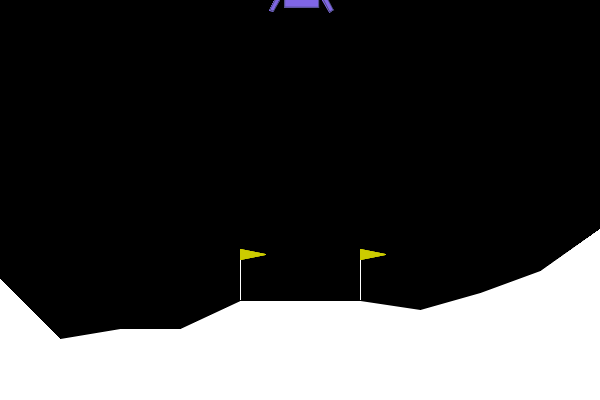

In [5]:
env.reset()
PIL.Image.fromarray(env.render())

In order to build our neural network later on we need to know the size of the state vector and the number of valid actions. We can get this information from our environment by using the `.observation_space.shape` and `action_space.n` methods, respectively.

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print(f"State Shape = {state_size}")
print(f"Number of Actions = {num_actions}")

State Shape = (8,)
Number of Actions = 4


## 5. Interacting with the Gym Environment

The Gym library implements the standard “agent-environment loop” formalism:

<br>
<center>
<video src = "./videos/rl_formalism.m4v" width="840" height="480" controls autoplay loop poster="./images/rl_formalism.png"> </video>
<figcaption style = "text-align:center; font-style:italic">Fig 1. Agent-environment Loop Formalism.</figcaption>
</center>
<br>

In the standard “agent-environment loop” formalism, an agent interacts with the environment in discrete time steps $t=0,1,2,...$. At each time step $t$, the agent uses a policy $\pi$ to select an action $A_t$ based on its observation of the environment's state $S_t$. The agent receives a numerical reward $R_t$ and on the next time step, moves to a new state $S_{t+1}$.

We can start taking actions in the environment by using the `.step()` method. Note that the agent can only take one action per time step. 

In the cell below we can select different actions and see how the returned values change depending on the action taken. Remember that in this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [7]:
initial_state = env.reset()

In [8]:
# select the action
action = 0

# run a single time step of the environment's dynamics with the given action
next_state, reward, done, _, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
  print(f"Initial State\t\t: {initial_state}")
  print(f"Action\t\t\t: {action}")
  print(f"Next State\t\t: {next_state}")
  print(f"Reward Received\t\t: {reward}")
  print(f"Episode Terminated\t: {done}")
  print(f"Info\t\t\t: {info}")

Initial State		: (array([-0.005, 1.410, -0.533, -0.039, 0.006, 0.121, 0.000, 0.000],
      dtype=float32), {})
Action			: 0
Next State		: [-0.011 1.409 -0.532 -0.065 0.012 0.119 0.000 0.000]
Reward Received		: -0.6308482726105638
Episode Terminated	: False
Info			: {}


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## 6. Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***.

### 6.1 Target Network

We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

where $w$ are the weights of the $Q$-Network. This means that we are adjusting the weights $w$ at each iteration to minimize the following error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Notice that this forms a problem because the $y$ target is changing on every iteration. Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create
a separate neural network for generating the $y$ targets. We call this separate neural network the **target $\hat Q$-Network** and it will have the same architecture as the original $Q$-Network. By using the target $\hat Q$-Network, the above error becomes:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights the target $\hat Q$-Network and $Q$-Network, respectively.

In practice, we will use the following algorithm: every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$. By using the soft update, we are ensuring that the target values, $y$, change slowly, which greatly improves the stability of our learning algorithm.

In [9]:
# Create the Q-Network
q_network = Sequential([
  Input(shape=state_size),
  Dense(units=128, activation='relu'),
  Dense(units=64, activation='relu'),
  Dense(units=num_actions, activation='linear')
])

# Create the Target Q^-Network
target_q_network = Sequential([    
  Input(shape=state_size),                      
  Dense(units=128, activation='relu'),            
  Dense(units=64, activation='relu'),            
  Dense(units=num_actions, activation='linear'),    
])

optimizer = Adam(learning_rate=ALPHA)

### 6.2 Experience Replay

By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [10]:
# store expericences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

## 7. Deep Q-Learning Algorithm with Experience Replay

In [11]:
def compute_loss(experiences, gamma, q_network, target_q_network):
  """ 
    Calculates the loss.
    
    Args:
      experiences       : (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma             : (float) The discount factor.
      q_network         : (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network  : (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between the y targets and the Q(s,a) values.
  """
  
  # unpack the mini-batch of experience tuples
  states, actions, rewards, next_states, done_vals = experiences
  
  # compute max Q^(s,a)
  max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
  
  # set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
  y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
  
  # get the q_values
  q_values = q_network(states)
  q_values = tf.gather_nd(
    q_values,
    tf.stack([tf.range(q_values.shape[0]),
              tf.cast(actions, tf.int32)],
             axis=1)
  )
  
  # compute the loss
  loss = MSE(y_targets, q_values)
  
  return loss

## 8. Update the Network Weights

In [12]:
@tf.function
def agent_learn(experiences, gamma):
  """
    Updates the weights of the Q networks.
    
    Args:
      experiences : (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma       : (float) The discount factor.
  """
  
  # calculate the loss
  with tf.GradientTape() as tape:
    loss = compute_loss(experiences, gamma, q_network, target_q_network)
  
  # get the gradients of the loss with respect to the weights
  gradients = tape.gradient(loss, q_network.trainable_variables)
  
  # update the weights of the q_network
  optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
  
  # update the weights of target q_network
  utils.update_target_network(q_network, target_q_network)

## 9. Train the Agent

In [13]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100  # number of total points to use for averaging
epsilon = 1.0   # initialize ε value for ε-greedy policy

# create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
  
  # reset the env to the initial state/obs space and get the initial state
  state, _ = env.reset()
  total_points = 0
  
  for t in range(max_num_timesteps):    
    # from the current states S choose an action A using an ε-greedy policy  
    state_qn = np.expand_dims(state, axis=0) # Expand dimensions of the numpy array                    
    q_values = q_network(state_qn)    
    action = utils.get_action(q_values, epsilon)
    
    # take action A and receive reward R and the next state S'
    next_state, reward, done, _, _ = env.step(action)
    
    # Store experience tuple (S,A,R,S') in the memory buffer.
    # We store the done variable as well for convenience.
    memory_buffer.append(experience(state, action, reward, next_state, done))
        
    # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
    update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
    if update:
      # Sample random mini-batch of experience tuples (S,A,R,S') from D
      experiences = utils.get_experiences(memory_buffer)
            
      # Set the y targets, perform a gradient descent step,
      # and update the network weights.
      agent_learn(experiences, GAMMA)
        
    state = next_state.copy()
    total_points += reward
        
    if done:
      break
  
  total_point_history.append(total_points)
  av_latest_points = np.mean(total_point_history[-num_p_av:])
  
  # Update the ε value
  epsilon = utils.get_new_eps(epsilon)
  
  print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
  
  if (i+1) % num_p_av == 0:
    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
  
  # We will consider that the environment is solved if we get an
  # average of 200 points in the last 100 episodes.
  
  if av_latest_points >= 200.0:
    print(f"\n\nEnvironment solved in {i+1} episodes!")
    q_network.save('lunar_lander_model.h5')
    
    break

tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -152.29
Episode 200 | Total point average of the last 100 episodes: -106.65
Episode 300 | Total point average of the last 100 episodes: -47.935
Episode 400 | Total point average of the last 100 episodes: 38.820
Episode 500 | Total point average of the last 100 episodes: 186.04
Episode 516 | Total point average of the last 100 episodes: 200.18

Environment solved in 516 episodes!

Total Runtime: 2464.67 s (41.08 min)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


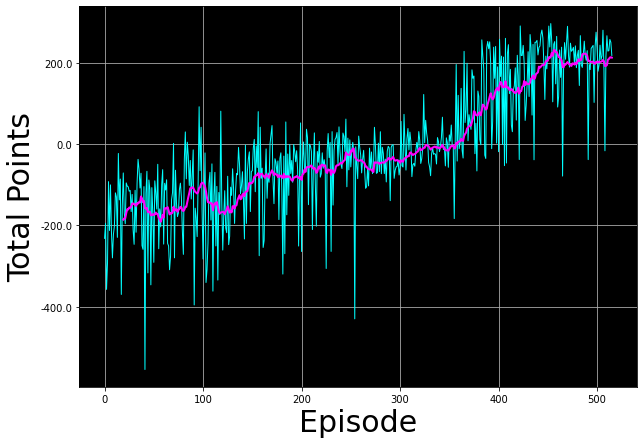

In [14]:
# Plot the point history
utils.plot_history(total_point_history)

In [15]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [16]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)